In [16]:
import math
import torch
import torch.optim as optim
import torch._dynamo
import matplotlib.pyplot as plt
pi = torch.tensor(math.pi)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [2]:
# 2D Rosenbrock function
def f(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

In [3]:
# 2D Rastrigin function
def f(x):
    return 20 + x[0]**2 + x[1]**2 - 10*(torch.cos(2*pi*x[0])+torch.cos(2*pi*x[1]))

In [89]:
# N-D Rastrigin function
def f(x):
    dim = x.shape[0]
    rastrigin=10*(dim)
    for i in range(dim):
        rastrigin+= x[i]**2 - 10*(torch.cos(2*pi*x[i]))
    return rastrigin

In [25]:
# N-D Rosenbrock function
def f(x):
    rosen=0.
    for i in range(x.shape[0]-1):
        rosen+=100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return rosen

In [105]:
# L-BFGS
import random
torch.manual_seed(0)
random.seed(0)

def closure():
    optimizer.zero_grad()
    f_eval = f(x_i)
    f_eval.backward()
    return f_eval

x_i = torch.rand(3, device="cpu")# + torch.randint(-5,5,(3,), device="cpu")
x_i = torch.tensor([0.1,0.1,0.1])
x_i.requires_grad = True
optimizer = optim.LBFGS([x_i],
                        lr=0.01,
                        max_iter=500, 
                        max_eval=None,
                        tolerance_grad=1e-07,
                        tolerance_change=1e-09,
                        history_size=100,
                        line_search_fn="strong_wolfe")

print(f"Initial x_i: {x_i}")

Initial x_i: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)


In [106]:
import torch._dynamo
torch._dynamo.reset()
f = torch.compile(f,options={'trace.graph_diagram':False,
                                'trace.enabled':False})

In [107]:
f_eval_prev = f(x_i)
%time optimizer.step(closure)
f_eval = f(x_i)

opt_state = optimizer.state_dict()
print(f"\nfn_evals: {opt_state['state'][0]['func_evals']}")
print(f"n_iter: {opt_state['state'][0]['n_iter']}")
print(f"x: {x_i}, fn_prev:{f_eval_prev} fn:{f_eval}")

CPU times: user 208 ms, sys: 218 µs, total: 209 ms
Wall time: 1.14 s

fn_evals: 53
n_iter: 16
x: tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005], requires_grad=True), fn_prev:11.5189790725708 fn:0.000247955322265625


In [85]:
%%time
counter = 0
while (f_eval_prev-f_eval) > 1e-10:
    counter+=1
    f_eval_prev = f_eval
    counter+=1
    optimizer.step(closure)
    f_eval = f(x_i)
    if not counter%1:
        print(f"x:{x_i}, fn:{f_eval}")
print(f"Steps: {counter}")
print(f"x:{x_i}, fn_prev:{f_eval_prev} fn:{f_eval}")

x:tensor([-0.5025,  4.5230, -1.5076], requires_grad=True), fn:-82.86602020263672
Steps: 2
x:tensor([-0.5025,  4.5230, -1.5076], requires_grad=True), fn_prev:-82.86602020263672 fn:-82.86602020263672
CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 1.89 ms


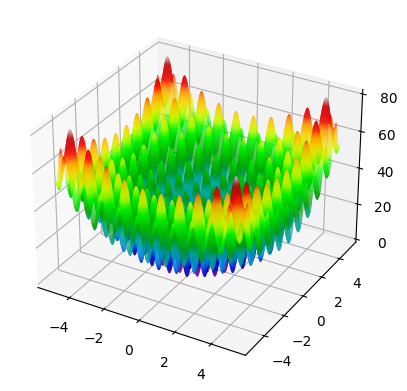

In [68]:
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
 
X = torch.arange(-5.12, 5.12, 0.01)     
Y = torch.arange(-5.12, 5.12, 0.01)     
X, Y = torch.meshgrid(X, Y, indexing='ij') 

Z = torch.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X[i].shape[0]):
        Z[i,j] = f(torch.tensor([X[i,j],Y[i,j]]))
    
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.savefig('rastrigin_graph.png')
plt.show()

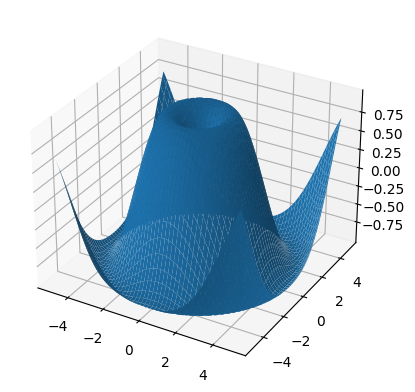

In [1]:
import torch
import matplotlib.pyplot as plt
xs = torch.linspace(-5, 5, steps=100)
ys = torch.linspace(-5, 5, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = torch.sin(torch.sqrt(x * x + y * y))
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()

In [21]:
X

tensor([[-5.1200, -5.1200, -5.1200,  ..., -5.1200, -5.1200, -5.1200],
        [-5.0200, -5.0200, -5.0200,  ..., -5.0200, -5.0200, -5.0200],
        [-4.9200, -4.9200, -4.9200,  ..., -4.9200, -4.9200, -4.9200],
        ...,
        [ 4.8800,  4.8800,  4.8800,  ...,  4.8800,  4.8800,  4.8800],
        [ 4.9800,  4.9800,  4.9800,  ...,  4.9800,  4.9800,  4.9800],
        [ 5.0800,  5.0800,  5.0800,  ...,  5.0800,  5.0800,  5.0800]])